In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../data/processed/jokes.csv')
df.head()

,text,target
0,"В женскую баню заходит слепой. Все закричали, ...",0
1,"На похоронах:\n– Да, ни одна женщина не могла ...",1
2,Соблюдение всех правил не гарантирует торжеств...,0
3,У дачников свой гороскоп. Летом они становятся...,0
4,"На работе думала - приду домой, уберусь, блинч...",0


In [3]:
df['target'].value_counts()

target
0    9500
1     655
Name: count, dtype: int64

In [4]:
# check if 'text' has NaN values
df = df.dropna()
# get index of NaN values
print(df['text'].isna().sum())
df['target'].value_counts()

0


target
0    9500
1     655
Name: count, dtype: int64

In [5]:
import sys
import os
sys.path.append('..')
from src.preprocess import preprocess_text, tokenize_text, vectorize

df['preprocessed'] = df.text.apply(preprocess_text)
df['tokenized'] = df['preprocessed'].apply(tokenize_text)
df['clean_text'] = df['tokenized'].apply(lambda x: " ".join(x))
df['vectorized'] = df.tokenized.apply(vectorize)
df.head()

[nltk_data] Downloading package stopwords to /home/qosquo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,target,preprocessed,tokenized,clean_text,vectorized
0,"В женскую баню заходит слепой. Все закричали, ...",0,в женскую баню заходит слепой все закричали ...,"[женский, баня, заходить, слепой, закричать, з...",женский баня заходить слепой закричать завизжа...,"[0.030757792, -0.027607756, -0.028811006, -0.0..."
1,"На похоронах:\n– Да, ни одна женщина не могла ...",1,на похоронах \n да ни одна женщина не могла ...,"[похороны, один, женщина, мочь, отказать, наст...",похороны один женщина мочь отказать настоящий ...,"[0.027943658, -0.006922857, -0.010546614, -0.0..."
2,Соблюдение всех правил не гарантирует торжеств...,0,соблюдение всех правил не гарантирует торжеств...,"[соблюдение, правило, гарантировать, торжество...",соблюдение правило гарантировать торжество закон,"[0.0045841113, -0.031044126, 0.005479594, 0.01..."
3,У дачников свой гороскоп. Летом они становятся...,0,у дачников свой гороскоп летом они становятся...,"[дачник, свой, гороскоп, лето, становиться, ра...",дачник свой гороскоп лето становиться рак водолей,"[0.0037249238, -0.030574461, -0.06956376, 0.01..."
4,"На работе думала - приду домой, уберусь, блинч...",0,на работе думала приду домой уберусь блинч...,"[работа, думать, прийти, домой, убраться, блин...",работа думать прийти домой убраться блинчик на...,"[0.00510795, -0.0052629793, -0.0068374737, 0.0..."


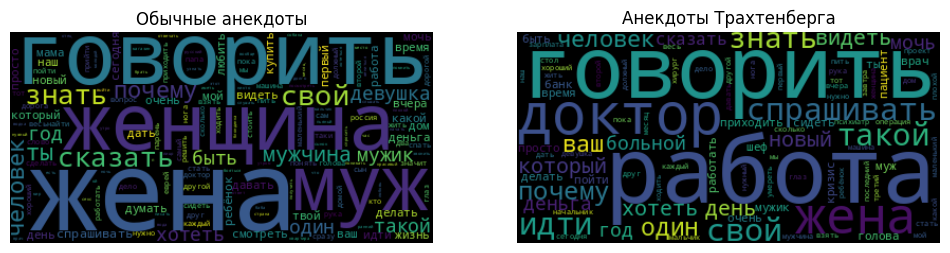

: 

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text_0 = " ".join(df[df.target == 0].clean_text.values)
text_1 = " ".join(df[df.target == 1].clean_text.values)
wordcloud_0 = WordCloud().generate(text_0)
wordcloud_1 = WordCloud().generate(text_1)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.title('Обычные анекдоты')
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Анекдоты Трахтенберга')
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = np.stack(df.vectorized.values)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# сравним распределение целевого признака
print(f"Train: {y_train.value_counts() / len(y_train)}")
print(f"Test: {y_test.value_counts() / len(y_test)}")

Train: target
0    0.935004
1    0.064996
Name: count, dtype: float64
Test: target
0    0.939961
1    0.060039
Name: count, dtype: float64


In [7]:
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
  ('resample', SMOTETomek(random_state=42, sampling_strategy=0.3)),
  ('clf', XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    scale_pos_weight=1/0.3,
    n_estimators=500,
    min_split_loss=0.01,
    learning_rate=0.1,
    tree_method='hist',
    reg_lambda=0.1,
    max_depth=3,
    eval_metric='aucpr',
    verbosity=0
  ))
])

pipeline.fit(X_train, y_train)
model = pipeline.named_steps['clf']

In [12]:
from sklearn.metrics import fbeta_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint
from sklearn.metrics import make_scorer

distributions = {
  'clf__lambda': loguniform(1e-2, 1e1),
  'clf__eta': uniform(0, 1),
  "clf__subsample": np.linspace(0.6, 1.0, 5),  # [0.6, 0.7, 0.8, 0.9, 1.0]
  "clf__colsample_bytree": np.linspace(0.6, 1.0, 5),
  "clf__gamma": [0, 0.1, 1, 5],
  "clf__reg_alpha": loguniform(1e-3, 1e1),  # L1-регуляризация
  "clf__n_estimators": randint(200, 1000)
}
clf = RandomizedSearchCV(pipeline, distributions, cv=5, scoring='f1')
search = clf.fit(X_train, y_train)
model = search.best_estimator_
print(search.best_params_)

{'clf__C': np.float64(5.93932395445364), 'clf__max_iter': 629, 'clf__tol': np.float64(1.8893027245692092e-05), 'resample__sampling_strategy': np.float64(0.8445458476464217)}


In [8]:
from sklearn.metrics import f1_score, fbeta_score, confusion_matrix
y_pred = model.predict(X_test)

X_train_res, y_train_res = pipeline.named_steps['resample'].fit_resample(X_train, y_train)
# метрики
print(f"Train F1: {f1_score(y_train_res, model.predict(X_train_res))}")
print(f"Test F1: {f1_score(y_test, y_pred)}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")

print(y_test[100:105])
model.predict_proba(X_test)[100:105]

Train F1: 0.9728188557308497
Test F1: 0.375
Confusion matrix:
[[912  43]
 [ 37  24]]
3080    0
6017    0
4957    0
8098    1
107     0
Name: target, dtype: int64


array([[0.9246878 , 0.0753122 ],
       [0.5318708 , 0.46812922],
       [0.95301217, 0.04698781],
       [0.24440384, 0.75559616],
       [0.6384157 , 0.36158428]], dtype=float32)

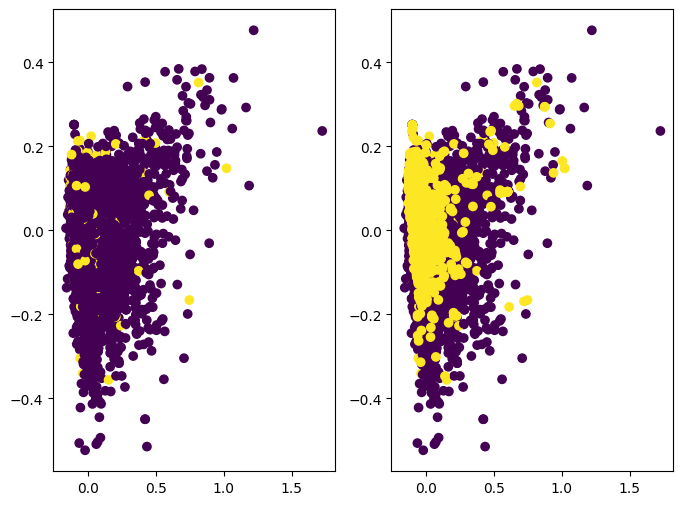

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# До SMOTE
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_train)

# После SMOTE
X_res_pca = pca.transform(X_train_res)
axes[1].scatter(X_res_pca[:, 0], X_res_pca[:, 1], c=y_train_res)
plt.show()

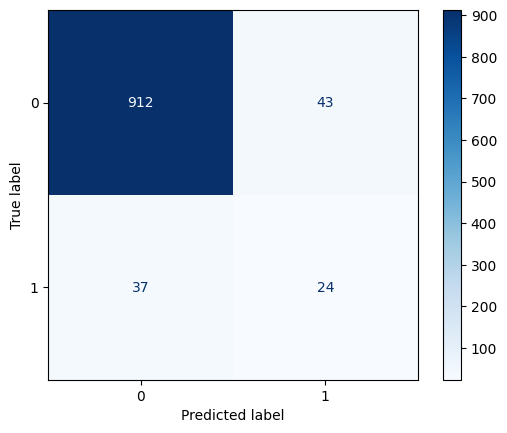

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
# матриц ошибок
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize=None)
plt.show()

Оптимальный порог: 0.5402, F1: 0.39


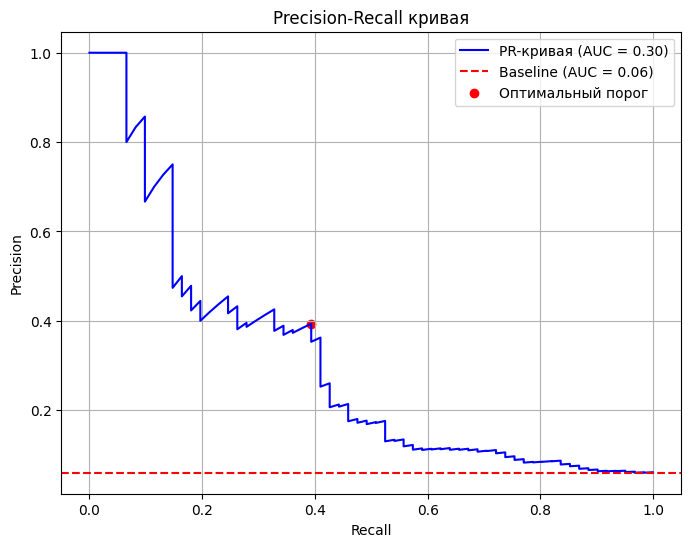

In [11]:
from sklearn.metrics import precision_recall_curve, auc

y_probs = model.predict_proba(X_test)[:, 1]
# Вычисляем precision, recall, пороги
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)  # Важно: передаем recall как x, precision как y

# Baseline (точность при случайном угадывании)
baseline = sum(y_test) / len(y_test)  # Доля положительных классов

# Строим график
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR-кривая (AUC = {pr_auc:.2f})', color='blue')
plt.axhline(baseline, linestyle='--', color='red', label=f'Baseline (AUC = {baseline:.2f})')

scores = 2 * (precision * recall) / (precision + recall + 1e-9)
# scores = (beta**2 + 1) * precision * recall / (beta**2 * precision + recall + 1e-9)
optimal_idx = np.argmax(scores)
optimal_threshold = thresholds[optimal_idx]
plt.scatter(recall[optimal_idx], precision[optimal_idx], marker='o', color='red', label='Оптимальный порог')
print(f"Оптимальный порог: {optimal_threshold:.4f}, F1: {scores[optimal_idx]:.2f}")

# Настройки
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# проверю невиданный ранее моделью анекдот
new_text = """Как-то раз зять приходит к теще и говорит: 'Теща, я тут решил заняться спортом, чтобы быть в форме и радовать вас своим атлетическим телосложением. Можно?' А теща отвечает: 'Конечно, сынок! Только не забудь надеть свой новый спортивный костюм, который я тебе подарила, и кроссовки, которые я тебе тоже подарила. И не забудь взять полотенце и бутылку воды. И, конечно, не забудь про наушники, чтобы слушать мои советы по тренировкам!'"""
new_text_clean = vectorize(tokenize_text(preprocess_text(new_text)))
model.predict_proba(np.stack([new_text_clean]))[0][1]

np.float32(0.14154692)

In [14]:
import joblib

joblib.dump(model, '../models/model.pkl')

['../models/model.pkl']